# In this example we select a list of science window and submit it to ODA to obtain an image

In [1]:
# with no surprise, we do it for the Crab
source_name='Crab'

## Astroquery can be used to retrieve the list

We build a convenience function.

For the scope of this socumentation, we make sure the `astroquery` library version, is within a specific version range. For newer (or older) version, please consult the offical documentation.

In [2]:
#Example of functions to select a science window list
import time

import astroquery.heasarc
from astropy.coordinates import SkyCoord
from astropy import units as u

Heasarc = astroquery.heasarc.Heasarc()


def get_scw_list(ra_obj, dec_obj,radius,start_date,end_date ):
    R = Heasarc.query_region(
            position = SkyCoord(ra_obj, dec_obj, unit='deg'),
            radius = f"{radius} deg",
            mission = 'intscw',
            time = start_date + " .. " + end_date,
            good_isgri = ">1000",
        )
    R.sort('SCW_ID')

    return R['SCW_ID'], R['SCW_VER']


assert astroquery.__version__ >= '0.4.2.dev6611' and astroquery.__version__ <= '0.4.7'

# it means it's our fork
assert 'isdc' in astroquery.heasarc.Conf.server.cfgtype

In [3]:
from astroquery.simbad import Simbad
from astropy import coordinates as coord

import json

import os
import shutil
import random

from astropy.io import fits

from scipy import stats
result_table = Simbad.query_object(source_name)
source_coord = coord.SkyCoord(result_table['RA'][0], result_table['DEC'][0], unit=("hourangle", "deg"))
ra=source_coord.ra.deg
dec=source_coord.dec.deg
radius=8.

- We get science windows within 10 degrees from the Crab position 
- between the given dates expressed in the ISOT format

In [4]:
scwlist,version = get_scw_list(ra,dec, 10, '2020-01-01T00:00:00', '2020-06-01T00:00:00')

- We pick at random nscw = 10 science window from the list (this is as ODA backend does)

In [5]:

nscw = 10
if len(scwlist) == 0:
    raise Exception('No science windows')

scw_pick = [(s+"."+v).strip() for s,v in zip(scwlist,version)]

if nscw >0 and len(scw_pick)>=nscw:
    random.seed(0)
    scw_pick = random.sample(scw_pick, nscw)
scw_pick = sorted(scw_pick)

In [6]:
scw_pick

['219400710010.001',
 '221000540010.001',
 '221200100010.001',
 '221400280010.001',
 '221400420010.001',
 '221400520010.001',
 '221500030010.001',
 '221500320010.001',
 '221500360010.001',
 '221500490010.001']

- Token for a given user 

In [7]:
token=''

In [8]:
#You can provide a valid token as explained in the 'Authentication' example or skip this cell
import getpass
token = getpass.getpass('Insert the token')

Insert the token········


## Let's get some logging

This is to help visualizing the progress.

- WANRING is the default level
- INFO writes some more information
- DEBUG is maily for developers and issue tracking


In [9]:
import logging
#default
#logging.getLogger().setLevel(logging.WARNING)
#slightly more verbose
logging.getLogger().setLevel(logging.INFO)
#all messages
#logging.getLogger().setLevel(logging.DEBUG)

logging.getLogger('oda_api').addHandler(logging.StreamHandler()) 

In [10]:
from oda_api.api import DispatcherAPI
from astroquery.simbad import Simbad
from astropy import units as u
from astropy.coordinates import SkyCoord

disp = DispatcherAPI(url="https://www.astro.unige.ch/mmoda/dispatch-data", instrument="mock")

# par_dict = {
# "E1_keV": "28",
# "E2_keV": "40",
# "detection_threshold": "7",
# "instrument": "isgri",
# "osa_version": "OSA11.2",
# "product": "isgri_image",
# "product_type": "Real",
# "scw_list": scw_pick,
# "integral_data_rights": "all-private"
# }

source_name="GX 1+4"
simbad = Simbad.query_object(source_name)
coord = SkyCoord(simbad['RA'], simbad['DEC'], unit=[u.hour, u.deg])

ra = coord.ra.deg
dec = coord.dec.deg

par_dict = {
"DEC": "%f" % dec,
"E1_keV": 28,
"E2_keV": 50,
"RA": "%f" % ra,
"T1": '2019-01-01T00:00:00',
"T2": '2019-03-31T23:59:59',
"radius": 8,
"src_name": source_name,
"max_pointings": 10,
"detection_threshold": "7.0",
"instrument": "isgri",
"integral_data_rights": "public",
"oda_api_version": "1.1.22",
"off_line": "False",
"osa_version": "OSA11.2",
"product": "isgri_image",
"product_type": "Real",
}

if token != '':
    par_dict.update({'token': token})

data_collection = disp.get_product(**par_dict)

found token in TokenLocation.FILE_CUR_DIR your token payload: {
    "email": "Gabriele.Barni@unige.ch",
    "exp": 1748257223,
    "msdone": false,
    "msfail": false,
    "mssub": false,
    "name": "gbarni",
    "roles": "authenticated user, administrator, user manager, content manager, general, integral-private-qla, magic, unige-hpc-full, public-pool-hpc, antares, sdss, apc, bitp, renku contributor, gallery contributor, job manager, developer, oda workflow developer, refresh-tokens",
    "sub": "Gabriele.Barni@unige.ch"
}
token expires in 1220.8 h
discovered token in environment
please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`
/home/gabriele/Workspace/oda_api/venv/lib/python3.8/site-packages

In [11]:
data_collection.mosaic_image_0_mosaic.show()

------------------------------
name: mosaic_image
meta_data dict_keys(['product', 'instrument', 'src_name', 'query_parameters'])
number of data units 6
------------------------------
data uniti 0 ,name: PRIMARY
data uniti 1 ,name: GROUPING
data uniti 2 ,name: ISGR-MOSA-IMA
data uniti 3 ,name: ISGR-MOSA-IMA
data uniti 4 ,name: ISGR-MOSA-IMA
data uniti 5 ,name: ISGR-MOSA-IMA


In [12]:
data_collection.mosaic_image_0_mosaic.show_meta()

------------------------------
product : mosaic
instrument : isgri
src_name : 
query_parameters : None
------------------------------


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 58526.447905 from DATE-OBS.
Set MJD-END to 58557.991262 from DATE-END'. [astropy.wcs.wcs]
/home/gabriele/Workspace/oda_api/venv/lib/python3.8/site-packages/oda_api/plot_tools.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.show()


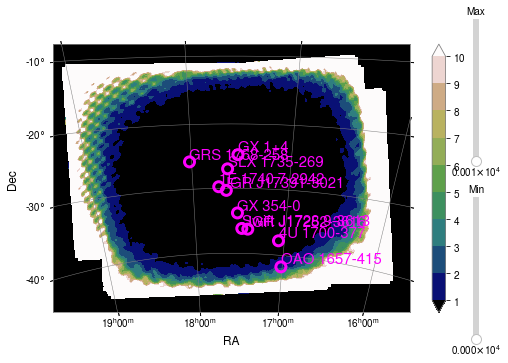

In [13]:
from oda_api.plot_tools import OdaImage
#interactive
%matplotlib inline

im=OdaImage(data_collection)
im.show(unit_ID=3)